In [12]:
from dlam.data.dataset import load_concat_dataset
from dlam.resnet.resnet import ResNet50
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import classification_report
import pickle
import matplotlib.pyplot as plt


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataclass = load_concat_dataset("train",transform=True, device=device)
test_dataclass = load_concat_dataset("test", transform=True, device=device)

trainloader = torch.utils.data.DataLoader([(X, y) for X, y in zip(train_dataclass["imgs"].unsqueeze(1), train_dataclass["labels"])], batch_size=256, shuffle=True)
testloader = torch.utils.data.DataLoader([(X, y) for X, y  in zip(test_dataclass["imgs"].unsqueeze(1), test_dataclass["labels"])], batch_size=256,shuffle=False)

In [ ]:
num_classes = len(train_dataclass["infos"][0]["label"])
classes = list(train_dataclass["infos"][0]["label"].values())
model = ResNet50(num_classes=num_classes, channels=1).double().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.05)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5, last_epoch=-1, verbose=False)


In [ ]:
def training(dataloader, device, model, criterion, scheduler):
    model.train()
    losses = []
    running_loss = 0
    
    pbar = tqdm(dataloader, unit="batch", desc="Training")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.view(-1).type(torch.LongTensor).to(device)
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
 
    avg_loss = sum(losses)/len(losses)
    scheduler.step()   

    return model, scheduler, avg_loss

def classify_dataloader(dataloader, device, model):
    model.eval()
    y_pred = []
    y_true = []
    losses = []
    running_loss = 0
    pbar = tqdm(dataloader, unit="batch", desc="Evaluating")

    with torch.no_grad():

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.view(-1).type(torch.LongTensor).to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)

            labels_predicted = outputs.argmax(1)
            for prediction, label in zip(labels_predicted, labels):
                y_pred.append(int(prediction))
                y_true.append(int(label))
            
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            
            running_loss += loss.item()
    
    avg_loss = sum(losses)/len(losses)
    report = classification_report(y_true, y_pred, target_names=classes)
    print(report)
    return y_true, y_pred, avg_loss, report

In [6]:
EPOCHS = 100
losses = {"train_loss": [],
          "test_loss": [],
          "test_predictions": [],
          "test_report": [],
          "model_path": []}

for epoch in range(1, EPOCHS+1):
    model, scheduler, avg_loss_train = training(trainloader, device, model, criterion, scheduler)
    y_true, y_pred, avg_loss_test, report = classify_dataloader(testloader, device, model)
    losses["train_loss"].append(avg_loss_train)
    losses["test_loss"].append(avg_loss_test)
    losses["test_predictions"].append(y_pred)
    losses["test_report"].append(report)
    model_path = f"../../../models/ResNet50original_epoch_{epoch}"
    losses["model_path"].append(model_path)

    torch.save(model, model_path)
    # Save the losses dictionary
    with open("../../../models/losses.pkl", "wb") as f:
        pickle.dump(losses, f)    

print('Training Done')

Training:  16%|█▌        | 39/241 [00:41<03:33,  1.06s/batch]


KeyboardInterrupt: 

In [7]:
file = open("../../../models/losses.pkl", "rb")
losses = pickle.load(file)




In [14]:
losses['train_loss']

[2.8186249308679225,
 1.1586793814357985,
 0.8126980153152824,
 0.6474565250271626,
 0.5125550508597647,
 0.4119342102865587,
 0.36190475556225216,
 0.28946099745695386,
 10.578070451517936,
 3.385898086384613,
 1.4443585766464713,
 1.93382256894071,
 1.1354580148014506,
 1.0431920883346322,
 0.9264023335137376,
 0.8129582457993793,
 0.763007980287366,
 0.7181682641924453]

In [15]:
losses['test_loss']

[1.593953480855441,
 1.1532063944695028,
 1.1174661793095402,
 1.0424337996064699,
 0.9001424162642045,
 1.2953934821119786,
 0.8296834311419726,
 0.9310300744963255,
 527036.2191761029,
 4.862228636733877,
 16.544078532792646,
 3.3053220779832317,
 2.8783504729380938,
 3.379891452001763,
 3.1364016413938733,
 2.5003439449723417,
 2.2642293481998124,
 2.2279974321243183]

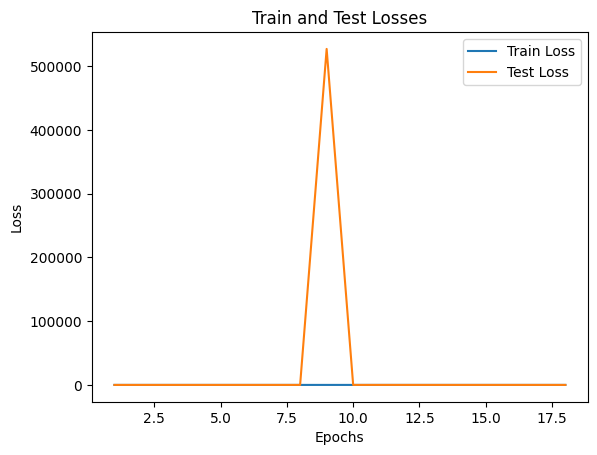

In [13]:
# Create x-axis values (epochs)
epochs = range(1, len(losses['train_loss']) + 1)

# Plot train and test losses
plt.plot(epochs, losses['train_loss'], label='Train Loss')
plt.plot(epochs, losses['test_loss'], label='Test Loss')


# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()

# Show the plot
plt.show()